In [1]:
%reload_ext autoreload
%autoreload 2
## sys package
import os, sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5"  # specify which GPU(s) to be used
sys.path.append("./prediction_models/input/prostate-cancer-grade-assessment/")
## warning off
import warnings
warnings.filterwarnings("ignore")

## general package
import random
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import torch
from torch.utils.data import *
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import pickle
# device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu") 
# print(device)

## customized package
from input.inputPipeline_stiching import PandaPatchDataset, crossValDataloader, data_transform
from model.resnext_ssl_stiching import Model_Infer as Model

In [5]:
data_dir = './input/panda-36x256x256-tiles-data/train'
csv_file = './input/panda-36x256x256-tiles-data/4_fold_whole_train.csv'
# SAMPLE = './input/prostate-cancer-grade-assessment/sample_submission.csv'

In [3]:
models = []
weights = [f'./train/weights/Resnext50_medreso_36patch_adam_cosine_bin/Resnext50_medreso_36patch_adam_cosine_bin_{i}_best.pth.tar' for i in [0,1,2,3]]
for path in weights:
    pretrained_dict = torch.load(path)
    model = Model(n = 5)
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(pretrained_dict)
    model.eval()
    model.cuda()
    models.append(model)

del pretrained_dict

In [6]:
sz = 256
bs = 1
folds = 4
tsfm = data_transform()
tsfm = None
dataset = PandaPatchDataset(csv_file, data_dir, sz, transform=tsfm, N = 36, rand = False)
crossValData = crossValDataloader(csv_file, dataset, bs)

In [7]:
names = [] ## record image names and predictions
preds = []
grades = []
preds_r, preds_k = [],[]
grades_r, grades_k = [],[]
for fold in [0,3]:
    ## Model inference
    _, dataloader0 = crossValData(fold)
    model = models[fold]
    with torch.no_grad():
        for idx, data in enumerate(tqdm(dataloader0)):
            img, name, provider, grade = data['img'], data['name'], data['datacenter'], data['isup_grade']
            img = img.cuda()
            logits = model(img)['out']
            preds.append(logits.sigmoid().sum(1).round().cpu())
            names.append(name)
            grades.append(grade.sum(1).cpu())
            if provider[0] == "radboud":
                preds_r.append(logits.sigmoid().sum(1).round().cpu())
                grades_r.append(grade.sum(1).cpu())
            else:
                preds_k.append(logits.sigmoid().sum(1).round().cpu())
                grades_k.append(grade.sum(1).cpu())
#             if idx >= 50:
#                 break

In [8]:
names = np.concatenate(names)
grades = torch.cat(grades, 0).numpy().astype(int)
predictions = torch.cat(preds, 0).numpy().astype(int)
grades_r = torch.cat(grades_r, 0).numpy().astype(int)
predictions_r = torch.cat(preds_r, 0).numpy().astype(int)
grades_k = torch.cat(grades_k, 0).numpy().astype(int)
predictions_k = torch.cat(preds_k, 0).numpy().astype(int)

In [37]:
kappa = cohen_kappa_score(grades, predictions, weights='quadratic')
kappa_r = cohen_kappa_score(grades_r, predictions_r, weights='quadratic')
kappa_k = cohen_kappa_score(grades_k, predictions_k, weights='quadratic')
cm = confusion_matrix(grades_r, predictions_r)
# ncm = cm / cm.astype(np.float).sum(axis=1)
ncm = cm
print("The average kappa score is {}, radboud is {}, karolinska is {}.".format(kappa, kappa_r, kappa_k))

The average kappa score is 0.8797552576025853, radboud is 0.8447190920511448, karolinska is 0.8890494430141944.


### Record a confusion dict with file name

In [27]:
val_preds_p, val_label_p = predictions_r, grades_r

In [28]:
cfm_name = {}
for i in range(6):
    for j in range(6):
        if i == j:
            continue
        cfm_name["{}_{}".format(i, j)] = [] ## label i, preds, j
for idx in range(len(val_label_p)):
    label = val_label_p[idx]
    preds = val_preds_p[idx]
    if label != preds:
        cfm_name["{}_{}".format(int(label), int(preds))].append("pseudo_name")

In [29]:
f = open("Resnext50_medreso_36patch_adam_cosine_bin_0_cfm_name_karolinska.pkl","wb")
pickle.dump(cfm_name,f)
f.close()

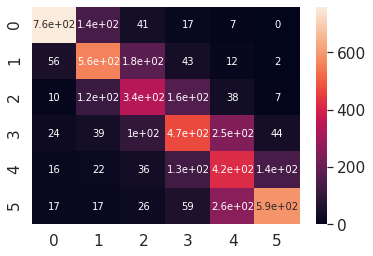

In [38]:
df_cm = pd.DataFrame(ncm, range(6), range(6))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
plt.show()